# Goal

* map-reduce langgraph example
* using a function to call a subgraph

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

In [3]:
model = ChatOpenAI(model="gpt-4o-mini")

In [4]:
# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 4 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
rating_prompt = """Generate rating from 1 (bad) to 10 (great) for the following joke: {joke}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""

In [43]:
class Subjects(BaseModel):
    subjects: list[str]

class Joke(BaseModel):
    joke: str

class Rating(BaseModel):
    rating: int

class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)


In [44]:
# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    ratings: Annotated[list, operator.add]
    best_selected_joke: str
    best_joke_rating: int

# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str
    joke: str
    rating: int

In [48]:
# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

def invoke_joke_rating(state: OverallState):
    response = subgraph.invoke({"subject": state["subject"]})
    return {"jokes": [response["joke"]], "ratings": [response["rating"]]}

# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"joke": response.joke}

# Here we generate a review of the joke
def generate_rating(state: JokeState):
    prompt = rating_prompt.format(joke=state["joke"])
    response = model.with_structured_output(Rating).invoke(prompt)
    return {"rating": response.rating, "joke": state["joke"]}

# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("invoke_joke_rating", {"subject": s}) for s in state["subjects"]]

# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {
        "best_selected_joke": state["jokes"][response.id],
        "best_joke_rating" : state["ratings"][response.id]
    }

In [49]:
#-- subgraph --#
subgraph = StateGraph(JokeState)

# nodes
subgraph.add_node("generate_joke", generate_joke)
subgraph.add_node("generate_rating", generate_rating)

# edges
subgraph.add_edge(START, "generate_joke")
subgraph.add_edge("generate_joke", "generate_rating")

# compile
subgraph = subgraph.compile()

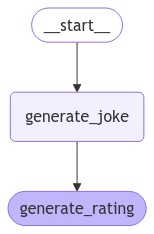

In [50]:
from IPython.display import Image

Image(subgraph.get_graph().draw_mermaid_png())

In [51]:

#-- graph --#
graph = StateGraph(OverallState)

# nodes
graph.add_node("generate_topics", generate_topics)
graph.add_node("invoke_joke_rating", invoke_joke_rating)
graph.add_node("best_joke", best_joke)

# edges
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["invoke_joke_rating"])
graph.add_edge("invoke_joke_rating", "best_joke")
graph.add_edge("best_joke", END)

# compile the graph
graph = graph.compile()

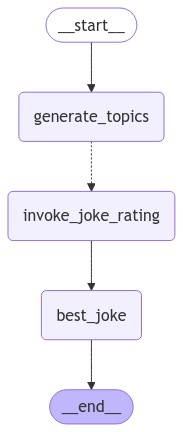

In [52]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [53]:
# Call the graph: here we call it to generate a list of jokes
for s in graph.stream({"topic": "animals"}, subgraphs=True, config={"max_concurrency" : 3}):
    print(s)

((), {'generate_topics': {'subjects': ['lion', 'elephant', 'dolphin', 'eagle']}})
(('invoke_joke_rating:9e3c4515-4d66-fdde-33ad-dd8c7078a071',), {'generate_joke': {'joke': 'Why don’t elephants use computers? Because they’re afraid of the mouse!'}})
(('invoke_joke_rating:b9b82b60-75ad-0185-e578-dd7509528d15',), {'generate_joke': {'joke': 'Why did the lion eat the tightrope walker? Because he wanted a well-balanced meal!'}})
(('invoke_joke_rating:b9b82b60-75ad-0185-e578-dd7509528d15',), {'generate_rating': {'joke': 'Why did the lion eat the tightrope walker? Because he wanted a well-balanced meal!', 'rating': 7}})
((), {'invoke_joke_rating': {'jokes': ['Why did the lion eat the tightrope walker? Because he wanted a well-balanced meal!'], 'ratings': [7]}})
(('invoke_joke_rating:9e3c4515-4d66-fdde-33ad-dd8c7078a071',), {'generate_rating': {'joke': 'Why don’t elephants use computers? Because they’re afraid of the mouse!', 'rating': 6}})
((), {'invoke_joke_rating': {'jokes': ['Why don’t elep